In [3]:
import os, json, random, math, time
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score

# Paths (train + val only)
BASE = Path("/kaggle/input/skin-classification-normal-acne-oily-dry-wrinkle/skin_dataset")
TRAIN_DIR = BASE / "train"
VAL_DIR   = BASE / "val"

WORK_DIR  = Path("/kaggle/working")
WORK_DIR.mkdir(parents=True, exist_ok=True)

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cuda'

Classes: ['Acne', 'Blackheads', 'Dark Spots', 'Dry Skin', 'Normal Skin', 'Oily Skin', 'Wrinkles']
Class → idx: {'Acne': 0, 'Blackheads': 1, 'Dark Spots': 2, 'Dry Skin': 3, 'Normal Skin': 4, 'Oily Skin': 5, 'Wrinkles': 6}

[Train counts]: {'Acne': 106, 'Blackheads': 90, 'Dark Spots': 98, 'Dry Skin': 71, 'Normal Skin': 112, 'Oily Skin': 103, 'Wrinkles': 141}
[Valid counts]: {'Acne': 106, 'Blackheads': 90, 'Dark Spots': 98, 'Dry Skin': 71, 'Normal Skin': 112, 'Oily Skin': 103, 'Wrinkles': 141}


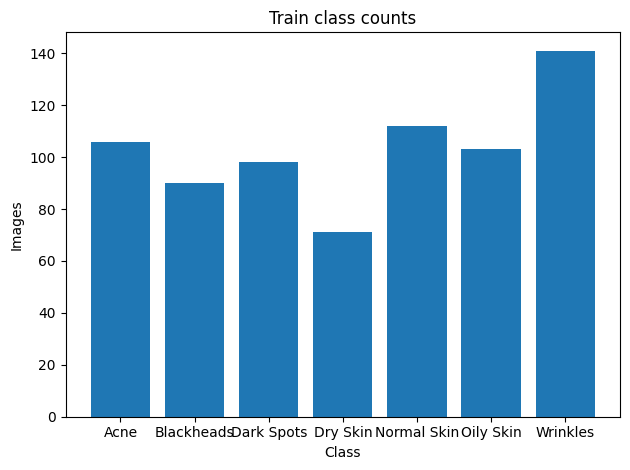

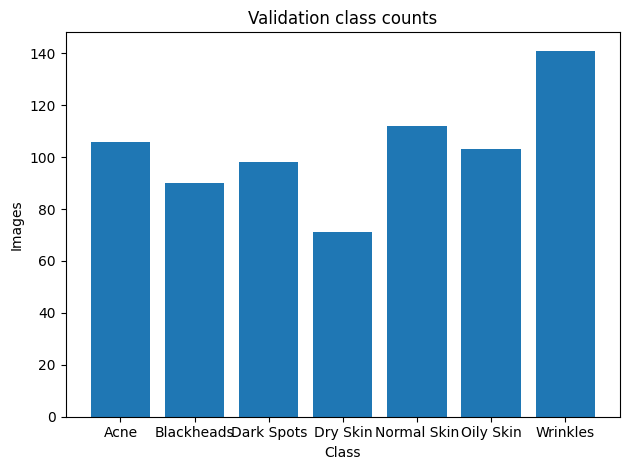

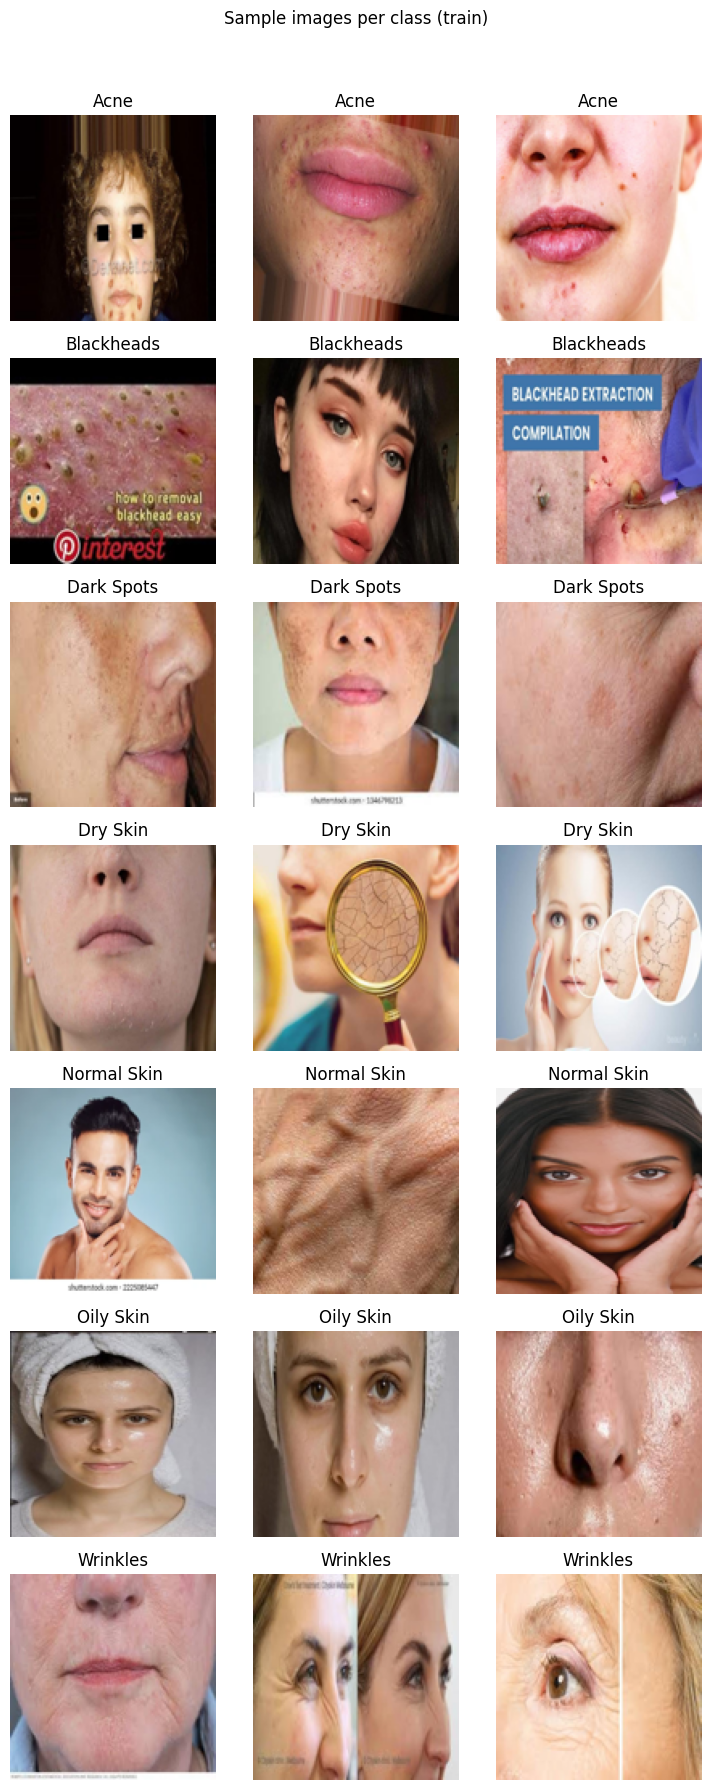


Saved labels → /kaggle/working/labels.txt
Saved class_to_idx → /kaggle/working/class_to_idx.json


In [4]:
from PIL import Image

tmp_train = datasets.ImageFolder(TRAIN_DIR)
classes = tmp_train.classes
class_to_idx = tmp_train.class_to_idx
print("Classes:", classes)
print("Class → idx:", class_to_idx)

def count_by_class(folder: Path, classes):
    ds = datasets.ImageFolder(folder)
    counts = {c: 0 for c in classes}
    for _, y in ds.samples:
        counts[classes[y]] += 1
    return counts

train_counts = count_by_class(TRAIN_DIR, classes)
val_counts   = count_by_class(VAL_DIR, classes)

print("\n[Train counts]:", train_counts)
print("[Valid counts]:", val_counts)

def plot_counts(title, counts):
    names = list(counts.keys())
    vals  = [counts[k] for k in names]
    plt.figure()
    plt.bar(names, vals)          # (no custom colors)
    plt.title(title)
    plt.xlabel("Class"); plt.ylabel("Images")
    plt.tight_layout(); plt.show()

plot_counts("Train class counts", train_counts)
plot_counts("Validation class counts", val_counts)

# Small grid of samples per class from train
def show_samples_per_class(root, classes, n_per_class=3, image_size=128):
    fig, axes = plt.subplots(len(classes), n_per_class, figsize=(n_per_class*2.5, len(classes)*2.5))
    if len(classes) == 1: axes = np.array([axes])
    for r, c in enumerate(classes):
        cls_dir = root / c
        paths = []
        for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.gif","*.tif","*.tiff","*.webp"):
            paths += list(cls_dir.glob(ext))
        random.shuffle(paths)
        for i in range(n_per_class):
            ax = axes[r, i] if n_per_class>1 else axes[r,0]
            if i < len(paths):
                im = Image.open(paths[i]).convert("RGB").resize((image_size, image_size))
                ax.imshow(im); ax.set_title(c)
            ax.axis("off")
    plt.suptitle("Sample images per class (train)", y=1.02)
    plt.tight_layout(); plt.show()

show_samples_per_class(TRAIN_DIR, classes, n_per_class=3, image_size=128)

# Save labels/mapping for later
(WORK_DIR / "labels.txt").write_text("\n".join(classes), encoding="utf-8")
(WORK_DIR / "class_to_idx.json").write_text(json.dumps(class_to_idx, indent=2))
print(f"\nSaved labels → {WORK_DIR/'labels.txt'}")
print(f"Saved class_to_idx → {WORK_DIR/'class_to_idx.json'}")


In [5]:
IMG_SIZE   = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

train_tfms = transforms.Compose([
    transforms.RandAugment(num_ops=2, magnitude=9),   # strong but safe
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.15,0.15,0.1,0.03)], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=val_tfms)

# Optional: WeightedRandomSampler to further counter imbalance (ON by default)
counts = Counter([y for _, y in train_ds.samples])
class_count = np.array([counts[i] for i in range(len(classes))])
class_weight = 1.0 / (class_count + 1e-6)
sample_weights = [class_weight[y] for _, y in train_ds.samples]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,    num_workers=NUM_WORKERS, pin_memory=True)

len(train_ds), len(val_ds), classes


(721,
 721,
 ['Acne',
  'Blackheads',
  'Dark Spots',
  'Dry Skin',
  'Normal Skin',
  'Oily Skin',
  'Wrinkles'])

In [6]:
# Cross-check weights for loss (complements sampler)
counts = Counter([y for _, y in train_ds.samples])
total = sum(counts.values())
freq  = np.array([counts[i] for i in range(len(classes))], dtype=np.float32)
loss_weights = total / (len(classes) * freq + 1e-6)
loss_weights = torch.tensor(loss_weights, dtype=torch.float32, device=DEVICE)
print("Train class counts:", counts)
print("Loss class weights:", loss_weights.cpu().numpy())


Train class counts: Counter({6: 141, 4: 112, 0: 106, 5: 103, 2: 98, 1: 90, 3: 71})
Loss class weights: [0.9716981  1.1444445  1.0510204  1.4507042  0.91964287 1.
 0.73049647]


In [7]:
# Stronger backbone for best results
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, len(classes))
model = model.to(DEVICE)

# Label smoothing helps calibration/generalization
criterion = nn.CrossEntropyLoss(weight=loss_weights, label_smoothing=0.05)

# Optimizer + OneCycleLR (fast, robust)
LR_MAX = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=LR_MAX, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR_MAX, steps_per_epoch=len(train_dl), epochs=20, pct_start=0.1
)

scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))
GRAD_CLIP_NORM = 1.0


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]
/tmp/ipykernel_36/3419092641.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))


In [8]:
def mixup_data(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, (y_a, y_b), lam

def mixup_criterion(crit, pred, y_a, y_b, lam):
    return lam * crit(pred, y_a) + (1 - lam) * crit(pred, y_b)


In [9]:
EPOCHS   = 20       # increase to 25–30 if time allows
PATIENCE = 4        # early stopping patience
best_val_balacc = -1.0
epochs_no_improve = 0

def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    return (preds == targets).float().mean().item()

for epoch in range(1, EPOCHS+1):
    # ---- Train ----
    model.train()
    tr_loss, tr_acc = 0.0, 0.0
    t0 = time.time()
    for imgs, ys in train_dl:
        imgs, ys = imgs.to(DEVICE), ys.to(DEVICE)
        optimizer.zero_grad()

        # MixUp
        imgs_m, (ya, yb), lam = mixup_data(imgs, ys, alpha=0.2)

        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            logits = model(imgs_m)
            loss = mixup_criterion(criterion, logits, ya, yb, lam)

        scaler.scale(loss).backward()
        if GRAD_CLIP_NORM is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        tr_loss += loss.item() * imgs.size(0)
        # Approx train acc (not exact with mixup, but indicative)
        tr_acc  += accuracy_from_logits(logits, ys) * imgs.size(0)

    tr_loss /= len(train_ds)
    tr_acc  /= len(train_ds)

    # ---- Validate ----
    model.eval()
    va_loss, va_acc = 0.0, 0.0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, ys in val_dl:
            imgs, ys = imgs.to(DEVICE), ys.to(DEVICE)
            logits = model(imgs)
            loss = criterion(logits, ys)
            va_loss += loss.item() * imgs.size(0)
            va_acc  += accuracy_from_logits(logits, ys) * imgs.size(0)

            preds = torch.argmax(torch.softmax(logits, dim=1), dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(ys.cpu().numpy())

    va_loss /= len(val_ds)
    va_acc  /= len(val_ds)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_bal_acc = balanced_accuracy_score(all_targets, all_preds)

    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{EPOCHS} | {dt:5.1f}s | "
          f"train_loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"val_loss {va_loss:.4f} acc {va_acc:.3f} bal_acc {val_bal_acc:.3f}")

    # Checkpoint on best balanced accuracy (handles imbalance better than raw acc)
    if val_bal_acc > best_val_balacc:
        best_val_balacc = val_bal_acc
        epochs_no_improve = 0
        torch.save({
            "state_dict": model.state_dict(),
            "classes": classes,
            "class_to_idx": class_to_idx,
            "arch": "resnet50",
            "img_size": IMG_SIZE,
            "normalization": {"mean":[0.485,0.456,0.406], "std":[0.229,0.224,0.225]},
        }, WORK_DIR / "skin_type_best.pth")
        print("  ✓ Saved best →", WORK_DIR / "skin_type_best.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping.")
            break


/tmp/ipykernel_36/1374664439.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 01/20 |  12.7s | train_loss 1.9045 acc 0.191 | val_loss 1.7611 acc 0.551 bal_acc 0.573
  ✓ Saved best → /kaggle/working/skin_type_best.pth


/tmp/ipykernel_36/1374664439.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 02/20 |   9.3s | train_loss 1.4819 acc 0.426 | val_loss 0.7504 acc 0.849 bal_acc 0.851
  ✓ Saved best → /kaggle/working/skin_type_best.pth


/tmp/ipykernel_36/1374664439.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 03/20 |   9.0s | train_loss 0.9328 acc 0.479 | val_loss 0.5665 acc 0.895 bal_acc 0.894
  ✓ Saved best → /kaggle/working/skin_type_best.pth


/tmp/ipykernel_36/1374664439.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 04/20 |   9.4s | train_loss 0.7583 acc 0.574 | val_loss 0.4435 acc 0.957 bal_acc 0.956
  ✓ Saved best → /kaggle/working/skin_type_best.pth


/tmp/ipykernel_36/1374664439.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 05/20 |   9.5s | train_loss 0.8214 acc 0.563 | val_loss 0.4276 acc 0.951 bal_acc 0.954


/tmp/ipykernel_36/1374664439.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 06/20 |   9.2s | train_loss 0.8757 acc 0.569 | val_loss 0.4287 acc 0.971 bal_acc 0.972
  ✓ Saved best → /kaggle/working/skin_type_best.pth


/tmp/ipykernel_36/1374664439.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 07/20 |   9.5s | train_loss 0.7234 acc 0.585 | val_loss 0.4213 acc 0.975 bal_acc 0.976
  ✓ Saved best → /kaggle/working/skin_type_best.pth


/tmp/ipykernel_36/1374664439.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 08/20 |   9.2s | train_loss 0.5910 acc 0.517 | val_loss 0.3453 acc 0.986 bal_acc 0.987
  ✓ Saved best → /kaggle/working/skin_type_best.pth


/tmp/ipykernel_36/1374664439.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 09/20 |   9.1s | train_loss 0.6012 acc 0.436 | val_loss 0.3289 acc 0.985 bal_acc 0.987


/tmp/ipykernel_36/1374664439.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 10/20 |   9.2s | train_loss 0.5510 acc 0.413 | val_loss 0.3236 acc 0.988 bal_acc 0.987
  ✓ Saved best → /kaggle/working/skin_type_best.pth


/tmp/ipykernel_36/1374664439.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 11/20 |   9.0s | train_loss 0.5493 acc 0.738 | val_loss 0.3005 acc 0.997 bal_acc 0.998
  ✓ Saved best → /kaggle/working/skin_type_best.pth


/tmp/ipykernel_36/1374664439.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 12/20 |   9.1s | train_loss 0.5672 acc 0.603 | val_loss 0.3006 acc 0.996 bal_acc 0.997


/tmp/ipykernel_36/1374664439.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 13/20 |   9.3s | train_loss 0.6190 acc 0.370 | val_loss 0.3158 acc 1.000 bal_acc 1.000
  ✓ Saved best → /kaggle/working/skin_type_best.pth


/tmp/ipykernel_36/1374664439.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 14/20 |   9.2s | train_loss 0.4925 acc 0.533 | val_loss 0.2835 acc 1.000 bal_acc 1.000


/tmp/ipykernel_36/1374664439.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 15/20 |   9.4s | train_loss 0.5195 acc 0.524 | val_loss 0.2928 acc 1.000 bal_acc 1.000


/tmp/ipykernel_36/1374664439.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 16/20 |   9.4s | train_loss 0.5932 acc 0.452 | val_loss 0.2921 acc 1.000 bal_acc 1.000


/tmp/ipykernel_36/1374664439.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):


Epoch 17/20 |  10.1s | train_loss 0.6519 acc 0.537 | val_loss 0.3089 acc 1.000 bal_acc 1.000
Early stopping.



Validation classification report:
              precision    recall  f1-score   support

        Acne     1.0000    1.0000    1.0000       106
  Blackheads     1.0000    1.0000    1.0000        90
  Dark Spots     1.0000    1.0000    1.0000        98
    Dry Skin     1.0000    1.0000    1.0000        71
 Normal Skin     1.0000    1.0000    1.0000       112
   Oily Skin     1.0000    1.0000    1.0000       103
    Wrinkles     1.0000    1.0000    1.0000       141

    accuracy                         1.0000       721
   macro avg     1.0000    1.0000    1.0000       721
weighted avg     1.0000    1.0000    1.0000       721

Balanced accuracy: 1.0
Confusion matrix:
 [[106   0   0   0   0   0   0]
 [  0  90   0   0   0   0   0]
 [  0   0  98   0   0   0   0]
 [  0   0   0  71   0   0   0]
 [  0   0   0   0 112   0   0]
 [  0   0   0   0   0 103   0]
 [  0   0   0   0   0   0 141]]


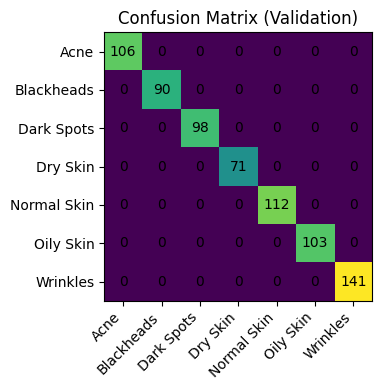

Saved eval → /kaggle/working/skin_type_eval_val.json


In [10]:
# Load best
ckpt = torch.load(WORK_DIR / "skin_type_best.pth", map_location=DEVICE)
model.load_state_dict(ckpt["state_dict"])
model.eval()

# Collect predictions on val
all_probs, all_preds, all_targets = [], [], []
with torch.no_grad():
    for imgs, ys in val_dl:
        imgs = imgs.to(DEVICE)
        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_targets.append(ys.numpy())

all_probs   = np.concatenate(all_probs)
all_preds   = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# Reports
print("\nValidation classification report:")
print(classification_report(all_targets, all_preds, target_names=classes, digits=4, zero_division=0))
print("Balanced accuracy:", balanced_accuracy_score(all_targets, all_preds))

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
print("Confusion matrix:\n", cm)

# Plot CM
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix (Validation)")
ax.set_xticks(np.arange(len(classes))); ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha="right"); ax.set_yticklabels(classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()

# Save eval stats
stats = {"classes": classes, "confusion_matrix": cm.tolist(), "balanced_accuracy": float(balanced_accuracy_score(all_targets, all_preds))}
(WORK_DIR / "skin_type_eval_val.json").write_text(json.dumps(stats, indent=2))
print("Saved eval →", WORK_DIR / "skin_type_eval_val.json")


In [11]:
# Save labels/mapping next to best model
(WORK_DIR / "labels.txt").write_text("\n".join(classes), encoding="utf-8")
(WORK_DIR / "class_to_idx.json").write_text(json.dumps(class_to_idx, indent=2))
print("Saved labels.txt and class_to_idx.json next to model.")

# Optional TorchScript export
try:
    example = torch.randn(1, 3, ckpt.get("img_size", IMG_SIZE), ckpt.get("img_size", IMG_SIZE)).to(DEVICE)
    scripted = torch.jit.trace(model, example)
    scripted.save(str(WORK_DIR / "skin_type_best.torchscript.pt"))
    print("Saved TorchScript →", WORK_DIR / "skin_type_best.torchscript.pt")
except Exception as e:
    print("TorchScript export skipped:", e)

# Minimal single-image inference helper (uses best model & labels)
from PIL import Image

def infer_image(image_path: str, model, classes, img_size=ckpt.get("img_size", IMG_SIZE)):
    tfm = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=ckpt["normalization"]["mean"], std=ckpt["normalization"]["std"]),
    ])
    with Image.open(image_path).convert("RGB") as im:
        x = tfm(im).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
    idx = int(np.argmax(probs))
    return classes[idx], float(probs[idx]), {c: float(probs[i]) for i, c in enumerate(classes)}

# Example usage:
# sample_img = str(next((TRAIN_DIR / classes[0]).glob("*.jpg")))  # pick any image
# pred_class, pred_prob, prob_dict = infer_image(sample_img, model, classes)
# print("Pred:", pred_class, pred_prob)


Saved labels.txt and class_to_idx.json next to model.
Saved TorchScript → /kaggle/working/skin_type_best.torchscript.pt
